In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import random
import numpy as np
import matplotlib.pyplot as plt

/home/eml/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def embed_generator(mean, cov):
    while True:
        yield np.random.multivariate_normal(mean, cov)

In [3]:
spk1 = embed_generator(np.array([0, 5]), np.array([[0.25, 0], [0, 0.25]]))

In [4]:
next(spk1)

array([0.34863971, 4.65514348])

In [5]:
class Speaker:
    def __init__(self, spk_id, spk_mean, spk_cov, acc_id, acc_mean, acc_cov):
        self.spk_id = spk_id
        self.acc_id = acc_id
        self.spk_embed = embed_generator(spk_mean, spk_cov)
        self.acc_embed = embed_generator(acc_mean, acc_cov)
        
    def get_embedding(self, mode="both"):
        # sample from embedding space and return based on mode
        #     "both"     => concatenated speaker and accent embedding (for joint)
        #     "speaker"  => just speaker embedding (for marginals)
        #     "accent"   => just speaker embedding (for marginals)
        
        spk = next(self.spk_embed)
        acc = next(self.acc_embed)
        
        if mode == "both":
            return np.concatenate([spk, acc])
        elif mode == "speaker":
            return spk
        elif mode == "accent":
            return acc
        else:
            raise ValueError("ERROR: mode must be in ['both', 'speaker', 'accent']")

In [6]:
spk_means = [
    np.array([0, 0, 20]),
    np.array([0, 0, -20])
]
spk_cov = np.zeros((3, 3))
np.fill_diagonal(spk_cov, 3)

acc_means = [
    np.array([x, y, z])
    for x in [-20, 20]
    for y in [-20, 20]
    for z in [-20, 20]
]
acc_cov = np.zeros((3, 3))
np.fill_diagonal(acc_cov, 3)

In [7]:
N_SPKS = 50
N_ACCS = 8
speakers = []
for _ in range(N_SPKS):
    spk_group = np.random.randint(2)
    acc_group = np.random.randint(N_ACCS)
    
    spk = Speaker(
        spk_group,
        spk_means[spk_group],
        spk_cov,
        acc_group,
        acc_means[acc_group],
        acc_cov
    )
    speakers.append(spk)
    
spk_group1 = [spk for spk in speakers if spk.spk_id == 0]
spk_group2 = [spk for spk in speakers if spk.spk_id == 1]

print(len(spk_group1))
print(len(spk_group2))

22
28


In [8]:
acc_groups = {
    f"group_{idx+1}": len([spk for spk in speakers if spk.acc_id == idx])
    for idx in range(N_ACCS)
}
acc_groups

{'group_1': 7,
 'group_2': 5,
 'group_3': 7,
 'group_4': 3,
 'group_5': 5,
 'group_6': 8,
 'group_7': 8,
 'group_8': 7}

In [9]:
test1 = speakers[0]
test2 = speakers[2]
test3 = speakers[4]

spk1_embeds = [test1.get_embedding(mode="speaker") for _ in range(200)]
spk2_embeds = [test2.get_embedding(mode="speaker") for _ in range(200)]
spk3_embeds = [test3.get_embedding(mode="speaker") for _ in range(200)]

acc1_embeds = [test1.get_embedding(mode="accent") for _ in range(200)]
acc2_embeds = [test2.get_embedding(mode="accent") for _ in range(200)]
acc3_embeds = [test3.get_embedding(mode="accent") for _ in range(200)]

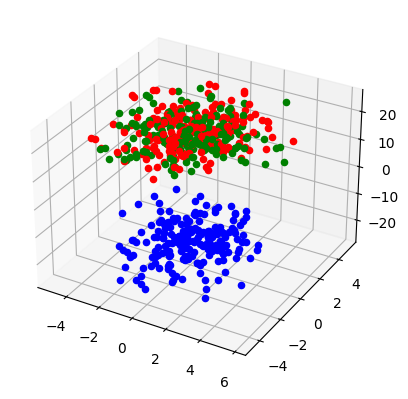

In [10]:
fig = plt.figure()
ax = plt.axes(projection="3d")
for embed in spk1_embeds:
    ax.scatter3D(*embed, label="spk1", c="r")
    
for embed in spk2_embeds:
    ax.scatter3D(*embed, label="spk2", c="g")
    
for embed in spk3_embeds:
    ax.scatter3D(*embed, label="spk3", c="b")
    

(-25.0, 25.0)

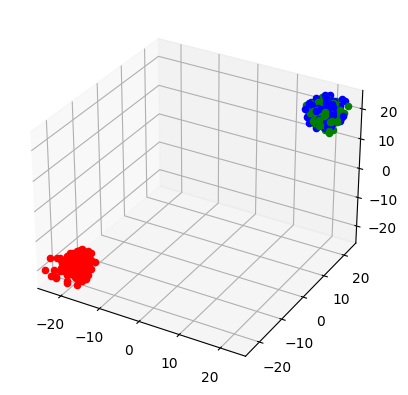

In [11]:
fig = plt.figure()
ax = plt.axes(projection="3d")
for embed in acc1_embeds:
    ax.scatter3D(*embed, label="spk1", c="r")
    
for embed in acc2_embeds:
    ax.scatter3D(*embed, label="spk2", c="g")
    
for embed in acc3_embeds:
    ax.scatter3D(*embed, label="spk3", c="b")
    
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_zlim([-25, 25])

In [12]:
class Mine(nn.Module):
    def __init__(self, input_size=6, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [13]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [14]:
def sample_batch(speakers, batch_size=100, sample_mode="joint"):
    spk_group1 = [spk for spk in speakers if spk.spk_id == 0]
    spk_group2 = [spk for spk in speakers if spk.spk_id == 1]   
    spk_group = random.choice([spk_group1, spk_group2])
    if sample_mode == "joint":
        samples = np.vstack([random.choice(spk_group).get_embedding() for _ in range(batch_size)])
    else:
        spk_samples = np.vstack(
            [random.choice(spk_group).get_embedding(mode="speaker") for _ in range(batch_size)]
        )
        acc_samples = np.vstack(
            [random.choice(speakers).get_embedding(mode="accent") for _ in range(batch_size)]
        )
        samples = np.concatenate([spk_samples, acc_samples], axis=1)
        
    return samples

In [15]:
def train(speakers, mine_net,mine_net_optim, batch_size=100, iter_num=int(1e+4), log_freq=int(2e+3)):
    # data is embed_map (dict of speaker and accent embeddings for each speaker)
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(speakers,batch_size=batch_size)\
        , sample_batch(speakers,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [16]:
def ma(a, window_size=1000):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [17]:
mine_net_test = Mine().cuda()
mine_net_optim = optim.Adam(mine_net_test.parameters(), lr=1e-3)
result_test = train(speakers, mine_net_test, mine_net_optim)

0.048288647
0.13528572
0.078725606
0.0640346
0.0093247965


0.06334241


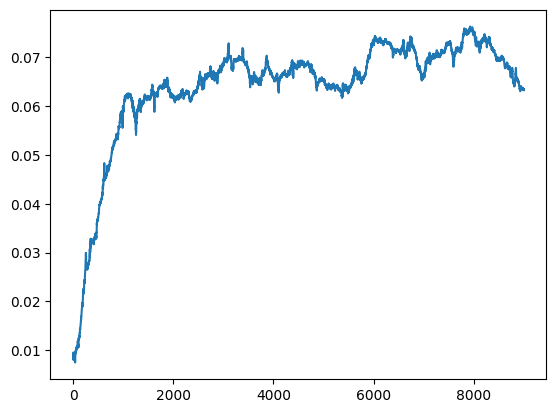

In [18]:
result_test_ma = ma(result_test)
print(result_test_ma[-1])
plt.plot(range(len(result_test_ma)), result_test_ma)

25:25 => 0.02, 0.04
26:24 => 0.04
27:23 => 0.18, 
28:22 => 0.11, 0.06
29:21 => 0.06 
30:20 => 0.05
31:19 => 0.07, 0.12
34:16 => 0.09